In [1]:
from IPython.display import set_matplotlib_formats
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import os

NAX = np.newaxis

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import handlers

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

#assert numpyro.__version__.startswith('0.6.0')
#numpyro.set_platform("gpu")

numpyro.set_platform("cpu")
#numpyro.set_host_device_count(5)

from scipy.integrate import simps
from jax.numpy import trapz

In [2]:
cd ..

/mnt/disk2/samarth/qdpy-numpyro


In [3]:
cd qdpy_jax

/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax


In [4]:
run rotation_kernels.py

[compute_Tsr] Time taken per iteration in seconds (no jax): , 5.582e-02 seconds
[get_Cvec] Time taken per iteration in seconds (no jax): , 7.439e-01 seconds


### Creating a simple qdPy script to test out pyro

In [5]:
def eig_mcmc_func(w1=None, w3=None, w5=None):
    return  get_eigs(create_supermatrix(w1, w3, w5))/2./omega0

def eig_mcmc_func_arr(warr=None):
    return  get_eigs(create_supermatrix_arr(warr))/2./omega0
    

#def create_supermatrix(wsr_slope):
def create_supermatrix(w1, w3, w5):
    integrand1 = Tsr[0, :] * w1
    integrand3 = Tsr[1, :] * w3
    integrand5 = Tsr[2, :] * w5
    integral1 = trapz(integrand1, x=r)
    integral3 = trapz(integrand3, x=r)
    integral5 = trapz(integrand5, x=r)
    prod_gamma1 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma3 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma5 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    wpi = (wigvals[:, 0]*integral1*prod_gamma1 + 
           wigvals[:, 1]*integral3*prod_gamma3 +
           wigvals[:, 2]*integral5*prod_gamma5)
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*(wigvals @ (prod_gammas * integral))
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*wpi
    diag = 8*np.pi*omega0*wpi
    supmat = jnp.diag(diag)
    return supmat

def create_supermatrix_arr(warr):
    integrand1 = Tsr[0, :] * warr[0]
    integrand3 = Tsr[1, :] * warr[1]
    integrand5 = Tsr[2, :] * warr[2]
    integral1 = trapz(integrand1, x=r)
    integral3 = trapz(integrand3, x=r)
    integral5 = trapz(integrand5, x=r)
    prod_gamma1 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma3 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma5 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    wpi = (wigvals[:, 0]*integral1*prod_gamma1 + 
           wigvals[:, 1]*integral3*prod_gamma3 +
           wigvals[:, 2]*integral5*prod_gamma5)
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*(wigvals @ (prod_gammas * integral))
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*wpi
    diag = 8*np.pi*omega0*wpi
    supmat = jnp.diag(diag)
    return supmat

def get_eigs(mat):
    eigvals, eigvecs = jnp.linalg.eigh(mat)
    return eigvals

def gamma(ell):
    return jnp.sqrt((2*ell+1)/4./np.pi)

def minus1pow_vecm(num):
    modval = num % 2
    retval = np.zeros_like(modval)
    retval[modval == 1] = -1
    retval[modval == 0] = 1
    return retval

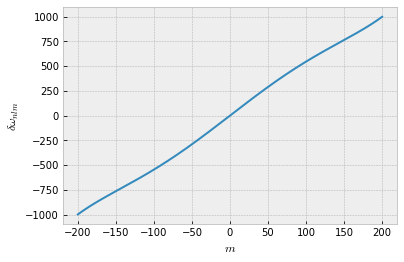

In [6]:
r = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/r.dat')
U = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/U3672.dat')
V = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/V3672.dat')

rmin, rmax = 0.3, 1.0
rmin_idx = np.argmin(abs(r - rmin))
rmax_idx = np.argmin(abs(r - rmax)) + 1

r = r[rmin_idx:rmax_idx]
U = U[rmin_idx:rmax_idx]
V = V[rmin_idx:rmax_idx]

r = jnp.asarray(r)
U = jnp.asarray(U)
V = jnp.asarray(V)
Tsr = jnp.asarray(Tsr)

n1, n2 = 0, 0
ell1, ell2 = 200, 200
ell = min(ell1, ell2)
nu0 = 4741.

Msol = 1.989e33
Rsol = 6.956e10
B0 = 10.e5
OM = jnp.sqrt(4*np.pi*Rsol*B0**2/Msol)
nu0 /= OM*1e6
omega0 = 2*jnp.pi*nu0

s_arr = jnp.array([1., 3., 5.])
m = jnp.arange(-ell, ell+1)
wigvals = np.zeros((2*ell+1, len(s_arr)))
for i in range(len(s_arr)):
    wigvals[:, i] = w3j_vecm(ell1, s_arr[i], ell2, -m, 0*m, m)
    
wigvals = jnp.asarray(wigvals)
w1t, w3t, w5t = 10.51, .43, .175
wmin_arr = np.array([0.1*w1t, 0.1*w3t, 0.1*w5t])
wmax_arr = np.array([3.1*w1t, 3.1*w3t, 3.1*w5t])
eigvals_true = get_eigs(create_supermatrix(w1t, w3t, w5t))/2/omega0

plt.figure()
plt.plot(m, eigvals_true)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()



In [7]:
def model():
    # setting min and max value to be 0.1*true and 3.*true
    wlist = []
    for i in range(3):
        wlist.append(numpyro.sample(f'w{i}', dist.Uniform(wmin_arr[i], wmax_arr[i])))
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.1, 10.0))
    eig_sample = numpyro.deterministic('eig', eig_mcmc_func_arr(warr=jnp.array(wlist)))
    return numpyro.sample('obs', dist.Normal(eig_sample, sigma), obs=eigvals_true)

In [8]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(12)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=50, num_samples=1000)#, num_chains=5)

In [9]:
mcmc.run(rng_key_)
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()
print(f"w1_true = {w1t}\n" +
     f"w3_true = {w3t}\n" +
     f"w5_true = {w5t}")

sample: 100%|██████████| 1050/1050 [01:58<00:00,  8.90it/s, 17 steps of size 2.91e-03. acc. prob=0.14]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      1.78      0.20      1.75      1.74      1.77     49.68      1.02
        w0     10.51      0.00     10.51     10.51     10.51    593.33      1.00
        w1      0.43      0.00      0.43      0.43      0.43     61.61      1.04
        w2      0.19      0.00      0.19      0.19      0.20      6.70      1.23

Number of divergences: 600
w1_true = 10.51
w3_true = 0.43
w5_true = 0.175


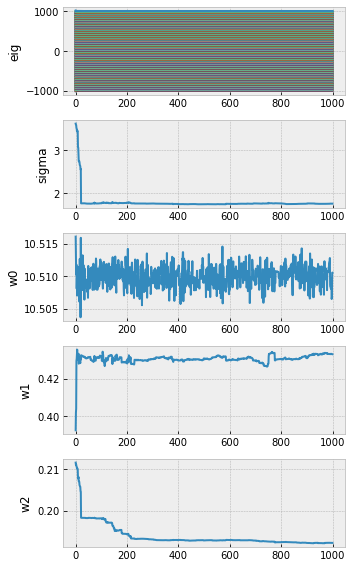

In [10]:
samples_1 = mcmc.get_samples()
fig, axs = plt.subplots(nrows=len(samples_1.keys()), ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()

/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


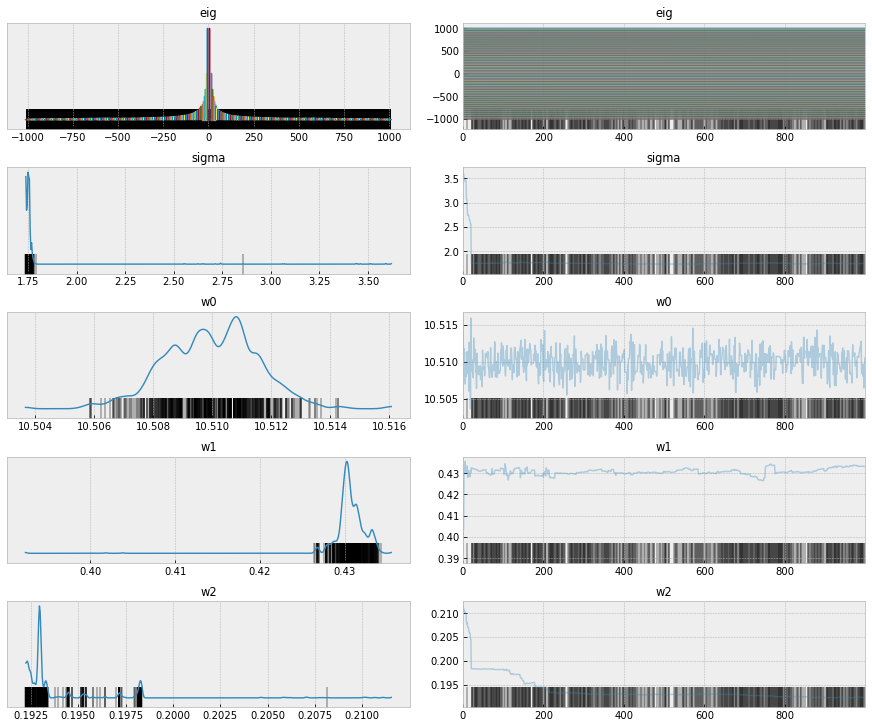

In [11]:
import arviz as az
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

NameError: name 'eig_samples' is not defined

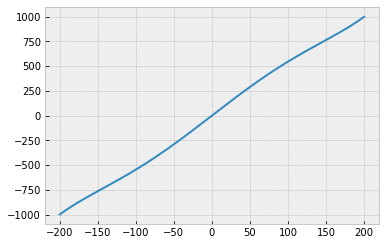

In [12]:
plt.figure()
plt.plot(m, eigvals_true)
for i in range(eig_samples.shape[0]):
    plt.plot(m, eig_samples[i, :], 'r', alpha=0.02)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()

In [18]:
np.save('mcmc.npy', mcmc.get_samples())

In [33]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [26]:
np_samples = {}
for key in samples_1.keys():
    vals = samples_1[key]
    np_samples[key] = np.array(vals)

In [34]:
save_obj(samples_1, 'mcmc-samples')

In [35]:
samples_2 = load_obj('mcmc-samples')

In [36]:
samples_2

{'eig': array([[-1011.34607, -1005.08575,  -998.9029 , ...,   998.9029 ,
          1005.08575,  1011.34607],
        [-1009.5635 , -1003.35297,  -997.2191 , ...,   997.2191 ,
          1003.35297,  1009.5635 ],
        [-1009.01965, -1002.8183 ,  -996.69354, ...,   996.69354,
          1002.8183 ,  1009.01965],
        ...,
        [-1001.0938 ,  -995.2719 ,  -989.5163 , ...,   989.5163 ,
           995.2719 ,  1001.0938 ],
        [-1001.46954,  -995.64557,  -989.8879 , ...,   989.8879 ,
           995.64557,  1001.46954],
        [-1001.46954,  -995.64557,  -989.8879 , ...,   989.8879 ,
           995.64557,  1001.46954]], dtype=float32),
 'sigma': array([3.6219065, 3.5960622, 3.589079 , 3.517654 , 3.5082278, 3.440569 ,
        3.4452782, 3.4602227, 3.4346874, 3.070208 , 3.061332 , 2.8585794,
        2.7407022, 2.74052  , 2.7451906, 2.713476 , 2.654306 , 2.6447947,
        2.6259246, 2.5523317, 2.5584998, 1.7578113, 1.7580705, 1.7580705,
        1.7580705, 1.7591835, 1.7595173, 1.759